### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/polimi/artificialneuraldeep


/gdrive/My Drive/polimi/artificialneuraldeep


### Import libraries

In [3]:
import os
import time 

import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load data 

Original image shape (828, 821)
Resized image shape (512, 512)


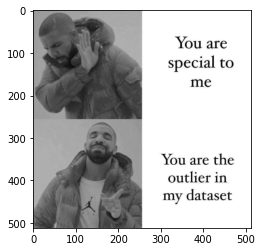

In [5]:
# Import the image as single channel
image = Image.open('picture.jpg').convert('L')
print("Original image shape", image.size)
image = image.resize((512,512))
print("Resized image shape", image.size)
fig = plt.figure(figsize=(4,4))
plt.imshow(image, cmap='gray')
plt.show()


In [16]:
# Convert the image into an array
image= np.array(image, dtype=np.float32)
image_h, image_w=image.shape


### 2D Convolution

$
\begin{align}
\sum_{s=-a}^{s=a}\sum_{t=-b}^{t=b}{w(s, t) f(x-s, y-t)}
\end{align}
$

![](https://drive.google.com/uc?export=view&id=1lr0M3W6LEedxZLXaCxt0JGjhmEjkHoq5
)

Implemented in Keras as cross-correlation!

$
\begin{align}
\sum_{s=-a}^{s=a}\sum_{t=-b}^{t=b}{w(s, t) f(x+s, y+t)}
\end{align}
$

### Example: Edge Detection

## Sobel Filter

##### - $w_h$: horizontal sobel filter
##### - $w_v$: vertical sobel filter

![](https://drive.google.com/uc?export=view&id=1jpP6QP4IzChc0eOw7UudQStKYWgZw6yn
)

Edges magnitude

$
\begin{align}
e(x,y) = \sqrt{e_h(x,y)^2 + e_v(x,y)^2}
\end{align}
$

In [10]:
# Function to plot image and filters
def plot_edges(orig_image, h_edge_image, v_edge_image, edge_image):
    print("Original image shape:", orig_image.shape)
    print("Horizontal edge image shape:", h_edge_image.shape)
    print("Vertical edge image shape:", v_edge_image.shape)
    print("Edge image shape:", edge_image.shape)

    fig, ax = plt.subplots(1, 4, figsize=(15, 45))
    ax[0].imshow(orig_image, cmap='gray')
    ax[1].imshow(h_edge_image, cmap='gray')
    ax[2].imshow(v_edge_image, cmap='gray')
    ax[3].imshow(edge_image, cmap='gray')
    plt.show()



In [14]:
# Define Sobel filters
# Horizontal filter
def kernel_h_init(shape, dtype=None, partition_info=None):
    kernel = tf.constant([[1, 0, -1],
                          [2, 0, -2],
                          [1, 0, -1]], dtype=dtype)
    kernel = tf.reshape(kernel, shape)
    return kernel
# Vertical filter
def kernel_v_init(shape, dtype=None, partition_info=None):
    kernel = tf.constant([[1, 2, 1],
                          [0, 0, 0],
                          [-1, -2, -1]], dtype=dtype)
    kernel = tf.reshape(kernel, shape)
    return kernel

In [ ]:
# Compute the edges by (manually) convolving the input with the filters
stride = 1
kernel_size = 3

h_kernel = kernel_h_init(shape=[3, 3], dtype=None)
v_kernel = kernel_v_init(shape=[3, 3], dtype=None)

h_edges = np.zeros([image_h, image_w])
v_edges = np.zeros([image_h, image_w])  
edges = np.zeros([image_h, image_w])

# Slide the filters over the image
for i in np.arange(0, image_h-kernel_size+1, stride):
    for j in np.arange(0, image_w-kernel_size+1, stride):
        # Apply the filter
        h_out = image[i:i+kernel_size, j:j+kernel_size] * h_kernel
        h_out = tf.reduce_sum(h_out)

        v_out = image[i:i+kernel_size, j:j+kernel_size] * v_kernel
        v_out = tf.reduce_sum(v_out)

        h_edges[i, j] = h_out
        v_edges[i, j] = v_out
        edges[i, j] = np.sqrt(h_out**2+v_out**2)

h_edges = h_edges[:image_h-kernel_size+1, :image_w-kernel_size+1]
v_edges = v_edges[:image_h-kernel_size+1, :image_w-kernel_size+1]
edges = edges[:image_h-kernel_size+1, :image_w-kernel_size+1]

In [ ]:
plot_edges(image, h_edges, v_edges, edges)

# 2D Convolutial Layer - tfk.layers.Conv2D

### Number of filters

![](https://drive.google.com/uc?export=view&id=1SggjDYVceiT04SM-Aza8eRzhkNZ9i3vs
)

### Filter size

![](https://drive.google.com/uc?export=view&id=1To2GJs-HDPbKZSRwu592V1CyQ4U5QY96
)

### Stride

![](https://drive.google.com/uc?export=view&id=1dacOoU5nBg_mSyd7K6E5F9uY_e3haIru
)

In [ ]:
# Create Conv2D layer


In [ ]:
h_edges_conv = conv2d_h(image[None, :, :, None]) # 'None' to add batch and channel dimensions
v_edges_conv = conv2d_v(image[None, :, :, None]) # 'None' to add batch and channel dimensions

h_edges_conv = h_edges_conv[0, :, :, 0]
v_edges_conv = v_edges_conv[0, :, :, 0]
edges_conv = np.sqrt(h_edges_conv**2+v_edges_conv**2)

In [ ]:
# Check the result of the "manual" convolution and 
# the result of the Keras convolution are the same 
assert np.allclose(h_edges, h_edges_conv)
print("OK. Horizontal edges are the same!")
assert np.allclose(v_edges, v_edges_conv)
print("OK. Vertical edges are the same!")
assert np.allclose(edges, edges_conv)
print("OK. Edge magnutides are the same!")

In [ ]:
plot_edges(image, h_edges_conv, v_edges_conv, edges_conv)

### Padding

In [ ]:
# What about input and Conv2D output shapes?


Original image shape: (512, 512)
Conv2D output shape: (510, 510)


Convolutions reduce the spatial dimension!

<img src="https://drive.google.com/uc?export=view&id=1kHpyc_-HRVM3J_8jqBTEYtIUAbWe4Ijv" width="256"/>

We need to add padding

<img src="https://drive.google.com/uc?export=view&id=1eEZhWEg_uuf44B14b0vUQZFmlpj36rm_" width="256"/>

$\tiny Images\ source:$ 
https://github.com/vdumoulin/conv_arithmetic





In [ ]:
# Create Conv2D layer with padding (horizontal)

# Create Conv2D layer with padding (vertical)

In [ ]:
h_edges_conv_pad = conv2d_pad_h(image[None, :, :, None]) # 'None' to add batch and channel dimensions
v_edges_conv_pad = conv2d_pad_v(image[None, :, :, None]) # 'None' to add batch and channel dimensions

h_edges_conv_pad = h_edges_conv_pad[0, :, :, 0]
v_edges_conv_pad = v_edges_conv_pad[0, :, :, 0]
edges_conv_pad = np.sqrt(h_edges_conv_pad**2+v_edges_conv_pad**2)

In [ ]:
# What about the shapes now?

In [ ]:
# If we remove the padding in the output, we obtain
# the same result of the convolution with no padding
assert np.allclose(h_edges_conv, h_edges_conv_pad[1:511, 1:511])
print("OK. Horizontal edges are the same!")
assert np.allclose(v_edges_conv, v_edges_conv_pad[1:511, 1:511])
print("OK. Vertical edges are the same!")
assert np.allclose(edges_conv, edges_conv_pad[1:511, 1:511])
print("OK. Edge magnutides are the same!")

# Learning the Conv2D filter

Suppose that the Sobel filter is unknown. Let's learn it!

In [ ]:
# Horizontal edge model
h_edge_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(learning_rate=1e-1))

# Vertical edge model
v_edge_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(learning_rate=1e-1))

In [ ]:
# Horizontal edge model training
h_edge_model.fit(
    x=
    y=
    epochs=3000, batch_size=1,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='loss', mode='min', patience=100, restore_best_weights=True)])

# Vertical edge model training
v_edge_model.fit(
    x=
    y=
    epochs=3000, batch_size=1,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='loss', mode='min', patience=100, restore_best_weights=True)])

In [ ]:
# Compare the learned filter with the Sobel one
learned_h_kernel = h_edge_model.weights[0].numpy()
learned_v_kernel = v_edge_model.weights[0].numpy()

print("Learned horizontal edge filter")
print()
print(learned_h_kernel[..., 0, 0].round(1))
print()
print("Learned vertical edge filter")
print()
print(learned_v_kernel[..., 0, 0].round(1))

In [ ]:
# Check if learned and original Sobel filters are the same
assert np.allclose(h_kernel, learned_h_kernel[..., 0, 0].round(1))
assert np.allclose(v_kernel, learned_v_kernel[..., 0, 0].round(1))
print("OK. Learned and original Sobel filters are the same!")

Surprise?

x = Wy + b, where x = {image}, y = {edge}

We have simply applied gradient descent to solve a linear equation :P

# Convolutional Neural Network (CNN)

<img src="https://drive.google.com/uc?export=view&id=1olry2CytupQhyiUPDgFR5gtH3lslbmJF" width="600"/>

## Architecture 
### Conv + Activation (+ Conv + Activation)$^+$ + Pooling + Fully-connected

# 2D Pooling

2D Average Pooling

* Reduces the spatial dimensions of features
* Reduces the number of parameters, then the complexity of the network
* Provides local translation invariance



In [ ]:
# Create example tensor 4x4


In [ ]:
# 2D Average Pooling


In [ ]:
# 2D Max Pooling


In [ ]:
# Global Average Pooling
